We can do better.

The default split criterion for scikit-learn `RandomForestRegressor` is `MSE`. The evaluation metric of this competition is the `RMSE` of the log of the actual versus predicted. If we transform our target variable our split criteria will now be on the same scale as our objective.

So this time:
- do a log transform to target variable

Looking better.
- Do we have any idea how this model might perform before submitting? **yes**
- Is this result repeatable? **yes**
- Can we make a better RF model? **yes**

In [2]:
%matplotlib inline

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, KFold, cross_val_predict
from sklearn.metrics import make_scorer, mean_squared_error

In [4]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [6]:
def load_data():
    train = pd.read_csv('../input/train.csv')
    test = pd.read_csv('../input/test.csv')
    combined = train.append(test, ignore_index=True).drop(['Id','SalePrice'], axis=1)
    combined = pd.get_dummies(combined)
    combined = combined.fillna(combined.mean())
    y = np.log(train['SalePrice'].values)
    X = combined.iloc[:train.shape[0],:]
    X_submission = combined.iloc[train.shape[0]:,:]
    ids_submission = test['Id'].values
    return y, X, X_submission, ids_submission

In [7]:
# loading data
y, X, X_submission, ids_submission = load_data()

# create CV folds
kf = KFold(10, random_state=1773, shuffle=True)

# define model
model = RandomForestRegressor(random_state=1773)

In [14]:
# evaluate model
scores = cross_val_score(model, X, y, cv=kf, scoring=make_scorer(rmse, greater_is_better=False))
print 'score (mean): %0.4f' % -scores.mean()
print 'score (std):  %0.4f' % scores.std()

score (mean): 0.1516
score (std):  0.0120


In [15]:
# evaluate model
scores = np.sqrt(-cross_val_score(model, X, y, cv=kf, scoring='neg_mean_squared_error'))
print 'score (mean): %0.4f' % scores.mean()
print 'score (std):  %0.4f' % scores.std()

score (mean): 0.1516
score (std):  0.0120


In [9]:
# plot CV preditions versus actuals
y_pred = cross_val_predict(model, X, y, cv=kf)

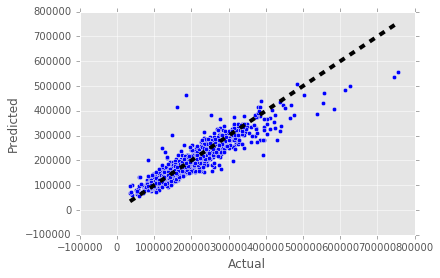

In [11]:
y_adj = np.exp(y)
y_pred_adj = np.exp(y_pred)

plt.style.use('ggplot')
fig, ax = plt.subplots()
ax.scatter(y_adj, y_pred_adj)
ax.plot([y_adj.min(), y_adj.max()], [y_adj.min(), y_adj.max()], 'k--', lw=4)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted');

In [12]:
# train model
model.fit(X, y)

# create submission predictions
preds_submission = model.predict(X_submission)

# save submission
pd.DataFrame({'Id': ids_submission, 'SalePrice': np.exp(preds_submission)})\
  .to_csv('../output/03_shift_random_forest.csv', index=False)